# FX Scorecard Drivers:

## 1. Interest Rate Differentials (Risk-adjusted Carry)
**Rationale:**
Higher domestic yields attract capital inflows as investors borrow in low-yield currencies and invest in high-yield ones, supporting high-yielding currencies

- JPMorgan 2011 + Deutsche 2002 say forward carry, which refers to changes in interest rate spreads, often has higher predictive power than static carry for FX moves because markets reprice future monetary policy/rate expectations
- JPMorgan 2011 also explicitly supports the use of risk-adjusted carry, which refers to yield differential ÷ realized 3M FX volatility, penalising high-yield currencies that are excessively volatile as carry is unattractive during volatility spikes, also outperforms static carry in out-of-sample testing

**Data:**
- 3M government yields (FRED)
- Realized FX volatility (60-day rolling standard deviation of daily returns)

## 2. Yield Curve Slope

**Rationale:**
The slope of the yield curve reflects domestic growth and policy expectations. A steep curve signals optimism and potential tightening --> currency appreciates, while a flat or inverted curve signals recession risk and dovish expectations --> currency depreciates

- Deutsche 2002 says G3 yield curves crucial for FX
- JPMorgan 2011 says slope changes help explain FX moves

**Data:**
- 10Y and 3M government bond yields (FRED, OECD)

## 3. Momentum
**Rationale:**
FX returns show persistence and exhibit trend-following behaviour because investors under-react to news by changing positions gradually instead of immediately, herding behaviour and stopping out of traders who are short (stop-loss cascades)

- Hafez 2021 and Deutsche 2002 agree that momentum and trend-following dominates short-run FX movements

**Data:**
- FX spot returns over 20-day horizons (yfinance)

## 4. Risk Sentiment
**Rationale:**
Risk-on favors high-beta FX (AUD, NOK, NZD) and risk-off strengthens safe havens (JPY, CHF only), EUR to be taken as neutral

- Deutsche 2002 says VIX & risk indicators central to FX moves, also says currencies with large current account deficits and high yields (AUD, NZD) are vulnerable in risk-off due to capital flight and carry unwinds
- JPMorgan 2011 explicitly notes that risk-on flows support EM and high-beta G10 FX while risk-off flows favor JPY and CHF
- Hafez 2021 says JPY, CHF = defensive, AUD, NZD, NOK = cyclical beta

**Data:**
- VIX (yfinance)

**Remarks:**
- JPMorgan 2011 highlights GBP vulnerability in equity selloffs and risk-off periods --> GBP will be bearish during risk-off situations, but not as much as high-beta FX

## 5. Equity Market Relative Performance

**Rationale:**
Stronger domestic equities attract foreign portfolio inflows --> currency appreciates, while weaker equities cause outflows --> currency depreciates

- JPMorgan 2011 says equity selloffs in a particualr country is a key FX driver
- Bertolini 2011 says FX factor returns (carry, momentum) collapse during equity market drawdowns because risk sentiment spills over from equities into FX

**Data:**
- Local equity indices (FTSE, DAX, Nikkei, ASX200, TSX, OMX etc.) relative to S&P 500 (yfinance)

## 6. Commodities
**Rationale:**
Currencies of commodity exporters move with their key export's prices as rising commodity prices improve trade balance, strengthening the currency
- Deutsche 2002 mentions commodity FX strongly tied to export prices
- Yelesh 2017 finds link between GDP/export dependence and FX depreciation/appreciation

**Data:**
- Oil (CL=F, BZ=F) for CAD/NOK
- Copper (HG=F) for AUD
- Broader commodity indices (DBC) for NZD

**Remarks:**
- CAD/NOK --> major oil exporters, crude and brent respectively, AUD --> copper and other industrial metals, NZD --> agricultural and dairy products but we use broad commodities (DBC) as a proxy while assigning it a reduced weight (0.5)

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from fredapi import Fred

In [2]:
def _date_window(days=365):
    today = pd.Timestamp.today().normalize()
    start = (today - pd.Timedelta(days=days)).strftime("%Y-%m-%d")
    end = today.strftime("%Y-%m-%d")
    return start, end

In [3]:
FX_TICKERS = {
    "EUR": "EURUSD=X",
    "GBP": "GBPUSD=X",
    "JPY": "USDJPY=X",
    "CHF": "USDCHF=X",
    "CAD": "USDCAD=X",
    "AUD": "AUDUSD=X",
    "NZD": "NZDUSD=X",
    "NOK": "USDNOK=X",
    "SEK": "USDSEK=X",
}
VIX_TICKER = "^VIX"
EQUITY_TICKERS = {
    "USD": "^GSPC",
    "EUR": "^STOXX50E",
    "GBP": "^FTSE",
    "JPY": "^N225",
    "CHF": "^SSMI",
    "CAD": "^GSPTSE",
    "AUD": "^AXJO",
    "NZD": "^NZ50",
    "NOK": "^OSEAX",
    "SEK": "^OMXSPI",
}
COMMODITY_TICKERS = {
    "WTI": "CL=F",
    "BRENT": "BZ=F",
    "COPPER": "HG=F",
    "DBC": "DBC",
}

In [4]:
def yf_download(tickers, start, end):
    # Debugging: Ensure list input for yfinance
    if isinstance(tickers, str):
        tickers = [tickers]

    df = yf.download(
        tickers,
        start=start,
        end=end,
        progress=False,
        auto_adjust=False
    )
    
    if "Adj Close" in df.columns:
        df = df["Adj Close"]
    elif "Close" in df.columns:
        df = df["Close"]
    else:
        raise KeyError("Neither 'Adj Close' nor 'Close' found in yfinance result.")

    # Debugging: If a single ticker yields a Series, make it a 1-col DataFrame
    if isinstance(df, pd.Series):
        df = df.to_frame(name=tickers[0])

    df = df.sort_index()
    return df

In [5]:
def yf_download_all(days=365, verbose=True):
    start, end = _date_window(days)

    # Download and rename, then invert USD/XXX to XXX/USD
    fx_raw = yf_download(list(FX_TICKERS.values()), start, end).rename(
        columns={v: k for k, v in FX_TICKERS.items()}
    ).sort_index(axis=1)
    for k in ["JPY", "CHF", "CAD", "NOK", "SEK"]:
        if k in fx_raw.columns:
            fx_raw[k] = 1.0 / fx_raw[k]
    fx = fx_raw

    vix = yf_download(VIX_TICKER, start, end).rename(columns={VIX_TICKER: "VIX"})

    eq = yf_download(list(EQUITY_TICKERS.values()), start, end).rename(
        columns={v: k for k, v in EQUITY_TICKERS.items()}
    ).sort_index(axis=1)

    cmd = yf_download(list(COMMODITY_TICKERS.values()), start, end).rename(
        columns={v: k for k, v in COMMODITY_TICKERS.items()}
    ).sort_index(axis=1)

    market_data = {
        "fx_spot": fx,
        "vix": vix,
        "equity_indices": eq,
        "commodities": cmd,
    }
    return market_data

In [6]:
def align(market_data, ffill=True):
    start = max(df.index.min() for df in market_data.values())
    end   = min(df.index.max() for df in market_data.values())
    common_idx = pd.bdate_range(start, end, freq="B")

    aligned = {}
    for k, df in market_data.items():
        d = df.reindex(common_idx)
        if ffill:
            d = d.ffill()
        aligned[k] = d.dropna()
    return aligned

def check_market_data(data):
    for k, df in data.items():
        print(f"\n=== {k} ===")
        print("Head:")
        print(df.head(3))
        print("Tail:")
        print(df.tail(3))
        print("=" * 40)

In [7]:
market_data = align(yf_download_all(days=365, verbose=True))
check_market_data(market_data)


=== fx_spot ===
Head:
Ticker           AUD       CAD       CHF       EUR       GBP       JPY  \
2024-11-08  0.667682  0.721121  1.145764  1.079517  1.298229  0.006528   
2024-11-11  0.658458  0.719021  1.141553  1.071490  1.291706  0.006540   
2024-11-12  0.657761  0.718313  1.136015  1.066439  1.287498  0.006516   

Ticker           NOK       NZD       SEK  
2024-11-08  0.091986  0.602228  0.093589  
2024-11-11  0.090962  0.596630  0.092426  
2024-11-12  0.090742  0.596912  0.092299  
Tail:
Ticker           AUD       CAD       CHF       EUR       GBP       JPY  \
2025-11-05  0.648560  0.709175  1.234065  1.148554  1.302170  0.006512   
2025-11-06  0.650991  0.709104  1.234980  1.149676  1.305260  0.006490   
2025-11-07  0.648390  0.708627  1.240849  1.154921  1.314095  0.006538   

Ticker           NOK       NZD       SEK  
2025-11-05  0.097802  0.564240  0.104375  
2025-11-06  0.097969  0.566900  0.104699  
2025-11-07  0.098099  0.563901  0.104511  

=== vix ===
Head:
Ticker        

In [8]:
FRED_10Y = {
    "USD": "DGS10",
    "GBP": "IRLTLT01GBM156N",
    "EUR": "IRLTLT01EZM156N",
    "JPY": "IRLTLT01JPM156N",
    "CHF": "IRLTLT01CHM156N",
    "CAD": "IRLTLT01CAM156N",
    "AUD": "IRLTLT01AUM156N",
    "NZD": "IRLTLT01NZM156N",
    "NOK": "IRLTLT01NOM156N",
    "SEK": "IRLTLT01SEM156N",
}
# FRED_2Y = {
#    "USD": "DGS2",
#    "GBP": "IRLTLT01GBA156N",
#    "EUR": "IRLTLT01EZA156N",
#    "JPY": "IRLTLT01JPA156N",
#    "CHF": "IRLTLT01CHA156N",
#    "CAD": "IRLTLT01CAA156N",
#    "AUD": "IRLTLT01AUA156N",
#    "NZD": "IRLTLT01NZA156N",
#    "NOK": "IRLTLT01NOA156N",
#    "SEK": "IRLTLT01SEA156N",
# }
FRED_3M = {
    "USD": "DGS3MO",
    "GBP": "IR3TIB01GBM156N",
    "EUR": "IR3TIB01EZM156N",
    "JPY": "IR3TIB01JPM156N",
    "CHF": "IR3TIB01CHM156N",
    "CAD": "IR3TIB01CAM156N",
    "AUD": "IR3TIB01AUM156N",
    "NZD": "IR3TIB01NZM156N",
    "NOK": "IR3TIB01NOM156N",
    "SEK": "IR3TIB01SEM156N",
}

In [9]:
def fred_yields_download(days=365, api_key=None, use_3m_for_short=True, verbose=True):
    fred = Fred(api_key=api_key)
    start, end = _date_window(days)

    def get_series(code):
        s = fred.get_series(code, observation_start=start, observation_end=end)
        return s

    ylong = {}
    for ccy, code in FRED_10Y.items():
        try:
            s = get_series(code)
            s.name = ccy
            ylong[ccy] = s
        except Exception as e:
            if verbose: print(f"[warn] 10Y {ccy} ({code}) failed: {e}")
    ylong = pd.concat(ylong.values(), axis=1).sort_index() if ylong else pd.DataFrame()

    # ymedium = {}
    # for ccy, code in FRED_2Y.items():
    #    try:
    #        s = get_series(code)
    #        s.name = ccy
    #        ymedium[ccy] = s
    #    except Exception as e:
    #        if verbose: print(f"[warn] 10Y {ccy} ({code}) failed: {e}")
    # ymedium = pd.concat(ymedium.values(), axis=1).sort_index() if ymedium else pd.DataFrame()

    yshort = {}
    for ccy, code in FRED_3M.items():
        try:
            s = get_series(code)
            s.name = ccy
            yshort[ccy] = s
        except Exception as e:
            if verbose: print(f"[warn] 3M {ccy} ({code}) failed: {e}")
    yshort = pd.concat(yshort.values(), axis=1).sort_index() if yshort else pd.DataFrame()

    def dailyize(df):
        if df.empty: return df
        # Build a business-day index from the first to the last date
        idx = pd.bdate_range(df.index.min(), df.index.max())
        # Reindexes the new series to the new index created above, then forward-filling so NaNs are filled with the last observation
        return df.reindex(idx).ffill()

    y10y = dailyize(ylong).dropna(how="all")
    # y2y = dailyize(ymedium).dropna(how="all")
    y3m  = dailyize(yshort).dropna(how="all")

    if verbose:
        print("yields_3m", y3m.shape, y3m.index.min().date(), y3m.index.max().date())
        # print("yields_2y", y2y.shape, y2y.index.min().date(), y2y.index.max().date())
        print("yields_10y", y10y.shape, y10y.index.min().date(), y10y.index.max().date())

    return {"yields_3m": y3m, "yields_10y": y10y}
    # return {"yields_3m": y3m, "yields_2y": y2y, "yields_10y": y10y}

def check_yields(yields, head_rows=3, tail_rows=3):
    for k, df in yields.items():
        print(f"\n=== {k} ===")
        if df.empty:
            print("(empty)")
            continue
        print("\nHead:")
        print(df.head(head_rows))
        print("\nTail:")
        print(df.tail(tail_rows))
        print("=" * 40)

In [10]:
yields_data = fred_yields_download(days=365)
check_yields(yields_data)

yields_3m (265, 10) 2024-11-01 2025-11-06
yields_10y (265, 10) 2024-11-01 2025-11-06

=== yields_3m ===

Head:
            USD   GBP       EUR    JPY       CHF   CAD   AUD   NZD  NOK  \
2024-11-01  NaN  4.68  3.006762  0.362  0.806508  3.48  4.42  4.42  4.7   
2024-11-04  NaN  4.68  3.006762  0.362  0.806508  3.48  4.42  4.42  4.7   
2024-11-05  NaN  4.68  3.006762  0.362  0.806508  3.48  4.42  4.42  4.7   

                SEK  
2024-11-01  2.66529  
2024-11-04  2.66529  
2024-11-05  2.66529  

Tail:
             USD   GBP       EUR   JPY       CHF     CAD   AUD   NZD   NOK  \
2025-11-04  3.96  3.97  2.027273  0.78 -0.059083  2.4925  3.58  2.93  4.13   
2025-11-05  3.96  3.97  2.027273  0.78 -0.059083  2.4925  3.58  2.93  4.13   
2025-11-06  3.93  3.97  2.027273  0.78 -0.059083  2.4925  3.58  2.93  4.13   

                SEK  
2025-11-04  1.98341  
2025-11-05  1.98341  
2025-11-06  1.98341  

=== yields_10y ===

Head:
            USD     GBP       EUR   JPY    CHF     CAD    AUD   N

In [11]:
def build_container(yf_data: dict, fred_yields: dict) -> dict:
    container = {}
    container.update(yf_data or {})
    container.update(fred_yields or {})
    return container

In [12]:
def synchronise_panels(container: dict, ffill=True, dropna=False):
    panels = {}
    for k, df in container.items():
        if isinstance(df, pd.DataFrame) and not df.empty:
            d = df.copy()
            if not isinstance(d.index, pd.DatetimeIndex):
                d.index = pd.to_datetime(d.index)
            panels[k] = d

    if not panels:
        return container

    start = max(df.index.min() for df in panels.values())
    end   = max(df.index.max() for df in panels.values())
    idx = pd.bdate_range(start, end, freq="B")

    synchronised = {}
    for k, df in panels.items():
        d = df.reindex(idx)
        if ffill:
            d = d.ffill()
        if dropna:
            d = d.dropna()
        synchronised[k] = d

    return synchronised

In [13]:
container = build_container(market_data, yields_data)
all_data = synchronise_panels(container, ffill=True, dropna=True)

def combine(data_dict, sep="_"):
    frames = []
    for key, df in data_dict.items():
        df_copy = df.copy()
        df_copy.columns = [f"{key}{sep}{col}" for col in df_copy.columns]
        frames.append(df_copy)

    combined = pd.concat(frames, axis=1).sort_index()
    return combined

raw_data = combine({
    "fx_spot": all_data["fx_spot"],
    "vix": all_data["vix"],
    "equity": all_data["equity_indices"],
    "commodities": all_data["commodities"],
    "yields_3m": all_data["yields_3m"],
    # "yields_2y": all_data["yields_2y"],
    "yields_10y": all_data["yields_10y"],
})

print(raw_data.head(3))
print(raw_data.tail(3))
print(raw_data.columns[:15])

# raw_data.to_csv("raw_data.csv", index=True)

# Temp: 2025-08-01 snapshot as no data after that date
# cutoff = pd.to_datetime("2025-08-02")
# raw_data.index = pd.to_datetime(raw_data.index)
# raw_data = raw_data.loc[raw_data.index < cutoff]
# print("Filtered date range:", raw_data.index.min(), "to", raw_data.index.max())
# raw_data.to_csv("raw_data.csv", index=True)

            fx_spot_AUD  fx_spot_CAD  fx_spot_CHF  fx_spot_EUR  fx_spot_GBP  \
2024-11-08     0.667682     0.721121     1.145764     1.079517     1.298229   
2024-11-11     0.658458     0.719021     1.141553     1.071490     1.291706   
2024-11-12     0.657761     0.718313     1.136015     1.066439     1.287498   

            fx_spot_JPY  fx_spot_NOK  fx_spot_NZD  fx_spot_SEK  vix_VIX  ...  \
2024-11-08     0.006528     0.091986     0.602228     0.093589    14.94  ...   
2024-11-11     0.006540     0.090962     0.596630     0.092426    14.97  ...   
2024-11-12     0.006516     0.090742     0.596912     0.092299    14.71  ...   

            yields_10y_USD  yields_10y_GBP  yields_10y_EUR  yields_10y_JPY  \
2024-11-08            4.30          4.4164        2.929132            1.05   
2024-11-11            4.30          4.4164        2.929132            1.05   
2024-11-12            4.43          4.4164        2.929132            1.05   

            yields_10y_CHF  yields_10y_CAD  yield

In [14]:
G10 = ["EUR","GBP","JPY","CHF","CAD","AUD","NZD","NOK","SEK"]

EQ_COL = {c: f"equity_{c}" for c in ["USD","EUR","GBP","JPY","CHF","CAD","AUD","NZD","NOK","SEK"]}
CMD_MAP = {
    "CAD": "commodities_WTI",     # WTI → CAD
    "NOK": "commodities_BRENT",   # Brent → NOK
    "AUD": "commodities_COPPER",  # Copper → AUD
    "NZD": "commodities_DBC",     # Broad commodities → NZD
}

def build_drivers(data: pd.DataFrame) -> pd.DataFrame:
    # Ensure unique, sorted datetimes
    data = data.copy()
    data.index = pd.to_datetime(data.index)
    data = data[~data.index.duplicated()].sort_index()

    out = pd.DataFrame(index=data.index)

    # Setup
    vix_cols = [c for c in data.columns if c.lower().startswith("vix_")]
    if vix_cols:
        vix_col = vix_cols[0]
        out[vix_col] = pd.to_numeric(data[vix_col], errors="coerce")

    # S&P 500 & 20d return for equity-relative
    spx = data[EQ_COL["USD"]].astype(float)
    spx_ret20d = spx.pct_change(20)

    # USD short rate
    y3m_USD = data["yields_3m_USD"].astype(float)

    for c in G10:
        # FX levels & returns
        fx = data[f"fx_spot_{c}"].astype(float)
        fx_logret = np.log(fx).diff()

        # Realized vol (annualised, 60d)
        fx_vol60d = fx_logret.rolling(60).std() * np.sqrt(252)
        vol_safe60 = fx_vol60d.clip(lower=1e-6)

        # Yields
        y3m_ccy = data[f"yields_3m_{c}"].astype(float)
        y10_ccy = data[f"yields_10y_{c}"].astype(float)

        # ----- (1) Carry driver: 5d change in vol-adjusted carry -----
        carry_spread = y3m_ccy - y3m_USD
        riskadj_carry = carry_spread / vol_safe60
        riskadjcarry_chg5d = riskadj_carry.diff(5)

        # ----- (2) Yield-curve slope driver: 5d change in (10Y - 3M) -----
        slope_level = y10_ccy - y3m_ccy
        slopechg5d = slope_level.diff(5)

        # ----- (3) Momentum: 20-day % return -----
        mom20d = fx.pct_change(20)

        # ----- (4) Equity-relative: local 20d % return − SPX 20d % return -----
        eq_local = data[EQ_COL[c]].astype(float)
        eq_rel20d = eq_local.pct_change(20) - spx_ret20d

        # ----- (5) Commodities: 20-day % return -----
        if c in CMD_MAP:
            cmd_ser = data[CMD_MAP[c]].astype(float)
            cmd20d = cmd_ser.pct_change(20)
        else:
            cmd20d = pd.Series(index=out.index, dtype=float)

        # Collect
        out[f"riskadjcarrychg5d_{c}"] = riskadjcarry_chg5d
        out[f"slopechg5d_{c}"]        = slopechg5d
        out[f"mom20d_{c}"]            = mom20d
        out[f"eq_rel20d_{c}"]         = eq_rel20d
        out[f"cmd20d_{c}"]            = cmd20d

    # Clean infinities / all-NaN rows
    out = out.replace([np.inf, -np.inf], np.nan)
    out = out.dropna(how="all")
    return out

In [15]:
drivers_df = build_drivers(raw_data)
print(drivers_df.shape)
print(drivers_df.tail(10))

drivers_df.to_csv("drivers.csv", index=True)

(261, 46)
              vix_VIX  riskadjcarrychg5d_EUR  slopechg5d_EUR  mom20d_EUR  \
2025-10-27  15.790000              -4.984765             0.0   -0.006537   
2025-10-28  16.420000              -3.196556             0.0   -0.006793   
2025-10-29  16.920000              -3.831717             0.0   -0.006645   
2025-10-30  16.910000              -2.945912             0.0   -0.011139   
2025-10-31  17.440001              -2.655234             0.0   -0.013019   
2025-11-03  17.170000              -1.718907             0.0   -0.015747   
2025-11-04  19.000000              -1.531779             0.0   -0.016323   
2025-11-05  18.010000              -1.255175             0.0   -0.014506   
2025-11-06  19.500000              -0.571324             0.0   -0.011623   
2025-11-07  19.080000              -1.200887             0.0   -0.001490   

            eq_rel20d_EUR  cmd20d_EUR  riskadjcarrychg5d_GBP  slopechg5d_GBP  \
2025-10-27       0.004964         NaN               1.277677             

In [16]:
G10 = ["EUR","GBP","JPY","CHF","CAD","AUD","NZD","NOK","SEK"]
SAFE_VOL_BULL = {"CHF", "JPY"}   # bullsh on high vol
VOL_NEUTRAL = {"EUR"}            # always neutral on vol
CMD_CCY = {"CAD","NOK","AUD","NZD"}

# Cross-sectional z-score function
def _zscore_cross_section(values: pd.Series):
    x = values.astype(float)
    mu = np.nanmean(x.values)
    sd = np.nanstd(x.values, ddof=0)
    if not np.isfinite(sd) or sd == 0:
        return pd.Series(0.0, index=values.index)
    return (x - mu) / sd

# Winsorise function
def _winsor(x: pd.Series, lo=-3.0, hi=3.0):
    return x.clip(lo, hi)

def make_fx_scorecard(
    drivers_df: pd.DataFrame,
    lookback_tag="20d",
    winsor_limits=(-3, 3),
    currencies=None
) -> pd.DataFrame:

    # Latest row of data
    last = drivers_df.sort_index().iloc[-1]

    # Infer currencies if not provided
    if currencies is None:
        currencies = sorted({col.split("_")[-1] for col in drivers_df.columns if "_" in col})
    idx = pd.Index(G10, name="ccy")
    out = pd.DataFrame(index=idx)

    # Helper function to extract a cross-section for a driver prefix
    def pull(prefix):
        cols = [f"{prefix}_{c}" for c in currencies if f"{prefix}_{c}" in last.index]
        vals = pd.Series(index=[c.split("_")[-1] for c in cols], dtype=float)
        for col in cols:
            vals[col.split("_")[-1]] = float(last[col])
        return vals.reindex(idx)

    # ===== 1) CARRY =====
    z_carry = _zscore_cross_section(pull("riskadjcarrychg5d"))
    out["carry"] = _winsor(z_carry, *winsor_limits)

    # ===== 2) YIELD CURVE =====
    z_slope = _zscore_cross_section(pull("slopechg5d"))
    out["yield_curve"] = _winsor(z_slope, *winsor_limits)

    # ===== 3) MOMENTUM =====
    mom = _zscore_cross_section(pull(f"mom{lookback_tag}"))
    out["momentum"] = _winsor(mom, *winsor_limits)

    # ===== 4) VOLATILITY =====
    VOL_BETA = {
        "CHF": +1.00,  # strongest safe haven
        "JPY": +0.50,  # safe haven but less than CHF
        "EUR":  0.00,  # neutral
        "GBP": -0.50,  # mild cyclical
        "CAD": -0.50,  # cyclical
        "AUD": -1.00,  # high cyclical
        "NZD": -1.00,  # high cyclical
        "NOK": -1.00,  # high cyclical
        "SEK": -1.00,  # high cyclical
    }
    vix_cols = [c for c in drivers_df.columns if c.lower().startswith("vix_")]
    vol_score = pd.Series(0.0, index=out.index, dtype=float)

    if vix_cols:
        vix_col = vix_cols[0]
        vix_series = pd.to_numeric(drivers_df[vix_col], errors="coerce").dropna()
        if not vix_series.empty:
            last_date = drivers_df.sort_index().index[-1]
            start_date = last_date - pd.DateOffset(years=5)
            vix_win = vix_series.loc[vix_series.index >= start_date]

            mu = float(np.nanmean(vix_win.values)) if len(vix_win) else np.nan
            sd = float(np.nanstd(vix_win.values, ddof=0)) if len(vix_win) else np.nan

            if np.isfinite(sd) and sd > 0:
                vix_z = float((vix_win.iloc[-1] - mu) / sd)
                for ccy in out.index:
                    beta = VOL_BETA.get(ccy, 0.0)
                    vol_score.loc[ccy] = beta * vix_z

    out["volatility"] = _winsor(vol_score, *winsor_limits)
    
    # ===== 5) EQUITY-RELATIVE =====
    eq_rel = _zscore_cross_section(pull(f"eq_rel{lookback_tag}"))
    out["equity_rel"] = _winsor(eq_rel, *winsor_limits)

    # ===== 6) COMMODITIES =====
    cmd_raw = pull(f"cmd{lookback_tag}")
    have_cmd = [c for c in currencies if c in CMD_CCY and pd.notna(cmd_raw.get(c))]
    cmd_score = pd.Series(0.0, index=idx)
    if len(have_cmd) >= 2:
        cmd_score.loc[have_cmd] = _zscore_cross_section(cmd_raw.loc[have_cmd])
    out["commods"] = _winsor(cmd_score, *winsor_limits)

    # Average across drivers (all drivers present for everyone; commods may be 0 for non-commodity CCYs), then rank
    driver_cols = ["carry", "yield_curve", "momentum", "volatility", "equity_rel", "commods"]
    out["avg_score"] = out[driver_cols].mean(axis=1)
    out = out.sort_values("avg_score", ascending=False)
    return out

In [17]:
scorecard = make_fx_scorecard(drivers_df, lookback_tag="20d")
print(scorecard)

        carry  yield_curve  momentum  volatility  equity_rel   commods  \
ccy                                                                      
JPY  1.253812          0.0  1.165769    0.039030    1.897476  0.000000   
NZD  1.116178          0.0 -1.861430   -0.078059    0.277025  1.705961   
SEK  0.326371          0.0  0.569819   -0.078059    0.157125  0.000000   
GBP  0.277703          0.0 -0.725279   -0.039030    1.060694  0.000000   
EUR -0.961032          0.0  0.922351    0.000000    0.121198  0.000000   
CHF -1.706964          0.0  1.199812    0.078059   -0.833675  0.000000   
AUD  0.483637          0.0 -0.644582   -0.078059   -1.123621 -0.286330   
CAD -1.293583          0.0  0.146848   -0.039030   -0.074572 -0.705446   
NOK  0.503880          0.0 -0.773309   -0.078059   -1.481652 -0.714185   

     avg_score  
ccy             
JPY   0.726014  
NZD   0.193279  
SEK   0.162543  
GBP   0.095681  
EUR   0.013753  
CHF  -0.210461  
AUD  -0.274826  
CAD  -0.327630  
NOK  -0.423887 


Driver weights per currency (equal weights):
- JPY: 5 drivers → weight = 0.200; used = carry, yield_curve, momentum, volatility, equity_rel
- SEK: 5 drivers → weight = 0.200; used = carry, yield_curve, momentum, volatility, equity_rel
- NZD: 6 drivers → weight = 0.167; used = carry, yield_curve, momentum, volatility, equity_rel, commods
- GBP: 5 drivers → weight = 0.200; used = carry, yield_curve, momentum, volatility, equity_rel
- EUR: 5 drivers → weight = 0.200; used = carry, yield_curve, momentum, volatility, equity_rel
- CHF: 5 drivers → weight = 0.200; used = carry, yield_curve, momentum, volatility, equity_rel
- AUD: 6 drivers → weight = 0.167; used = carry, yield_curve, momentum, volatility, equity_rel, commods
- CAD: 6 drivers → weight = 0.167; used = carry, yield_curve, momentum, volatility, equity_rel, commods
- NOK: 6 drivers → weight = 0.167; used = carry, yield_curve, momentum, volatility, equity_rel, commods

FX Scorecard Date: 2025-11-07


,carry,yield_curve,momentum,volatility,equity_rel,commods,weighted_score
JPY,1.25,0.00,1.17,0.04,1.90,nan,0.87
SEK,0.33,0.00,0.57,-0.08,0.16,nan,0.20
NZD,1.12,0.00,-1.86,-0.08,0.28,1.71,0.19
GBP,0.28,0.00,-0.73,-0.04,1.06,nan,0.11
EUR,-0.96,0.00,0.92,0.00,0.12,nan,0.02
CHF,-1.71,0.00,1.20,0.08,-0.83,nan,-0.25
AUD,0.48,0.00,-0.64,-0.08,-1.12,-0.29,-0.27
CAD,-1.29,0.00,0.15,-0.04,-0.07,-0.71,-0.33
NOK,0.50,0.00,-0.77,-0.08,-1.48,-0.71,-0.42


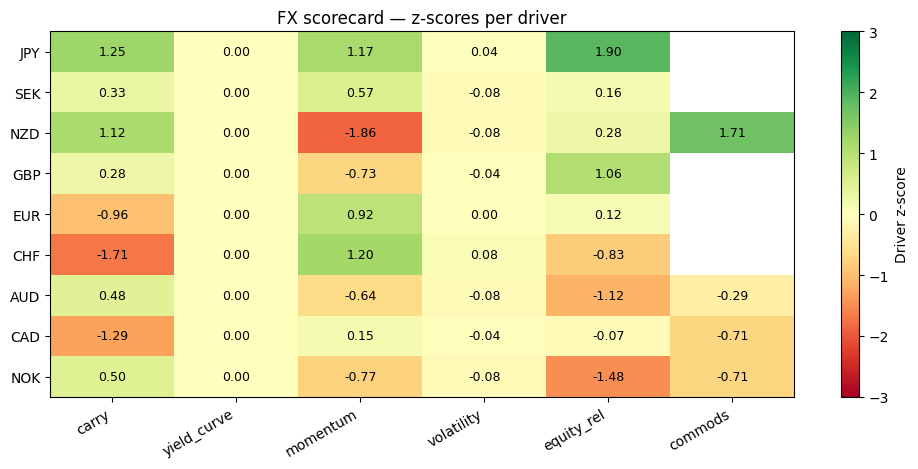

In [19]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

DRIVER_ORDER = ["carry", "yield_curve", "momentum", "volatility", "equity_rel", "commods"]
present_drivers = [d for d in DRIVER_ORDER if d in scorecard.columns]
scorecard = scorecard.copy()

# Remove 'commods' for non-commodity currencies
if "commods" in scorecard.columns:
    scorecard.loc[~scorecard.index.isin(CMD_CCY), "commods"] = np.nan

scorecard["weighted_score"] = scorecard[present_drivers].mean(axis=1)
ordered_cols = present_drivers + ["weighted_score"]
scorecard = scorecard[ordered_cols].sort_values("weighted_score", ascending=False)
scorecard.index.name = None

# Checking weights: 1/5 for non-commods, 1/6 for commods
presence = scorecard[present_drivers].notna().astype(float)
counts = presence.sum(axis=1)
weights_matrix = presence.div(counts, axis=0).fillna(0.0)

print("\nDriver weights per currency (equal weights):")
for ccy in weights_matrix.index:
    n = int(counts.loc[ccy])
    if n == 0:
        print(f"- {ccy}: no drivers available")
    else:
        w = 1.0 / n
        used = [d for d in present_drivers if weights_matrix.loc[ccy, d] > 0]
        print(f"- {ccy}: {n} drivers → weight = {w:.3f}; used = {', '.join(used)}")

# Get the last date from the drivers DataFrame
last_date = drivers_df.index.max().strftime("%Y-%m-%d")

# Add caption / print date
print(f"\nFX Scorecard Date: {last_date}")

# Scorecard
try:
    styled = (
        scorecard.style
        .format("{:.2f}")
        .background_gradient(subset=["weighted_score"], cmap="RdYlGn")
        .set_caption("FX scorecard")
    )
    display(styled)
except NameError:
    print("\nScorecard:")
    print(scorecard.round(1))

# Heatmap of z-scores
driver_cols = [c for c in DRIVER_ORDER if c in scorecard.columns]
mat = scorecard[driver_cols].to_numpy()

fig, ax = plt.subplots(figsize=(10, 4.8))
norm = Normalize(vmin=-3, vmax=3)
im = ax.imshow(mat, aspect="auto", cmap="RdYlGn", norm=norm)

ax.set_xticks(range(len(driver_cols)))
ax.set_xticklabels(driver_cols, rotation=30, ha="right")
ax.set_yticks(range(len(scorecard.index)))
ax.set_yticklabels(scorecard.index)

for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
        if not np.isnan(mat[i, j]):
            ax.text(j, i, f"{mat[i, j]:.2f}", ha="center", va="center", fontsize=9)

cbar = fig.colorbar(ScalarMappable(norm=norm, cmap="RdYlGn"), ax=ax)
cbar.set_label("Driver z-score")
ax.set_title("FX scorecard — z-scores per driver")
plt.tight_layout()
plt.show()